### 01 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

### 02 하이퍼파라미터 셋팅

In [2]:
# hyper-parameters
sequence_length=28
input_size=28
hidden_size=128
num_layers=2

num_classes=10
batch_size=100
num_epochs=2
learning_rate=0.01

In [3]:
# Device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 03 MNIST train, test dataset 가져오기

In [4]:
# mnist dataset
mnist_train=dset.MNIST("",train=True, transform=transforms.ToTensor(),
                      target_transform=None, download=True)
mnist_test=dset.MNIST("",train=False, transform=transforms.ToTensor(),
                      target_transform=None, download=True)

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


### 04 데이터 확인

In [5]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

mnist_train 길이:  60000
mnist_test 길이:  10000


In [6]:
image,label=mnist_train.__getitem__(0) # 0번째 데이터 형태 확인하기
print("image data 형태: ", image.size())
print("label: ", label)

image data 형태:  torch.Size([1, 28, 28])
label:  5


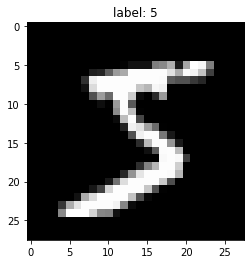

In [8]:
img=image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0],cmap='gray')
plt.show()

### 05 데이터 로드함수
학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [9]:
train_loader=torch.utils.data.DataLoader(dataset=mnist_train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=True) # batch_size만큼 나눌 때 나머지는 버려라

test_loader=torch.utils.data.DataLoader(dataset=mnist_test,
                                        batch_size=batch_size,
                                        shuffle=False, # test에선 shuffle하지 않음
                                        drop_last=True)

### 05-1 데이터 로드함수 이해하기

[0]
 한 번에 로드되는 데이터 크기 100


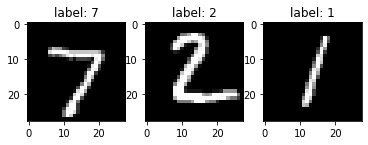

[1]
 한 번에 로드되는 데이터 크기 100


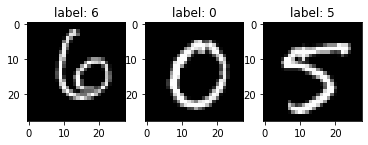

[2]
 한 번에 로드되는 데이터 크기 100


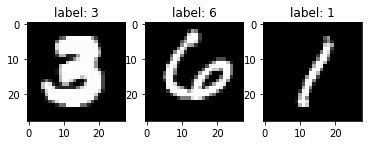

[3]
 한 번에 로드되는 데이터 크기 100


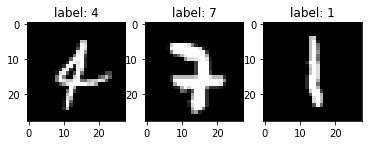

[4]
 한 번에 로드되는 데이터 크기 100


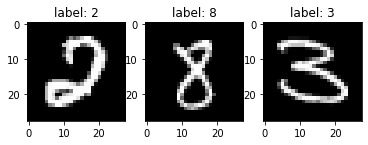

[5]
 한 번에 로드되는 데이터 크기 100


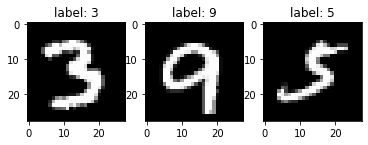

In [11]:
n=3 # 샘플로 그려볼 데이터 개수

for i, [imgs,labels] in enumerate(test_loader):
    if i>5:
        break
    print("[%d]" %i)
    print(" 한 번에 로드되는 데이터 크기", len(imgs))
    
    # 그리기
    for j in range(n):
        img=imgs[j].numpy()
        img=img.reshape((img.shape[1],img.shape[2])) # (1,28,28) -> (28,28)으로 color차원 없앰
        
        plt.subplot(1,n,j+1) # (1,3)형태 plot의 j번째 자리에 그린다
        plt.imshow(img,cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

### 06 모델 선언

In [12]:
# RNN(many-to-one)
class RNN(nn.Module):
    def __init__(self,input_sie,hidden_size,num_layers,num_classes):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,num_classes) # fully-connected
        
    def forward(self,x):
        # input tensor: (batch_size, seq_length, input_size)
        # x: (100,28,28)
        
        # hidden state tensor: (# of layers, batch_size, hidden_size)
        # h: (2,100,128)
        h0=torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)
        
        # 순전파 LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        # out: (100,28,128)
        
        out, _ = self.lstm(x,(h0,c0))
        
        # 28번째 output layer: (bs, hidden_size)
        # out[:, -1, :]: (100,128)
        
        out=self.fc(out[:, -1, :])
        
        # y^: (batch_size, num_classes)
        # y_pred: (100,100)
        
        return out

In [13]:
model=RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [14]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size만큼
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img=imgs
        img=img.reshape(-1,sequence_length, input_size).to(device)
        
        # y: (batch_size, num_classes)
        label=labels.to(device)
        # label= Variable(labels).cuda()
        #.cuda(): GPU에 로드되기 위함. 만양 CPU로 설정되어있다면 에러남
        
        # Forward prop.
        output=imodel(img) # (batch_size, num_classes)
        _, output_index=torch.max(output,1) # (batch_size, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    return (100*correct/total).numpy()

In [16]:
print("Accuracy of test data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of test data: 8.92


### 06 loss, optimizer

In [17]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
### 07 학습
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs,labels] in enumerate(train_loader):
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img=imgs
        img=img.reshape(-1, sequence_length, input_size).to(device)
        
        # y: (batch_size, num_classes)
        label=labels.to(device)
        
        # forward prop
        outputs=model(img)
        loss=loss_func(outputs,label)
        
        # back prop & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 ==0:
            print("Epoch  [{}/{}], Step [{},{}], Loss: {:.4f}, Accr: {:.2f}"
                 .format(epoch+1, num_epochs, i+1, total_step,
                 loss.item(), ComputeAccr(test_loader, model)))

Epoch  [1/2], Step [100,600], Loss: 0.1564, Accr: 94.62
Epoch  [1/2], Step [200,600], Loss: 0.0673, Accr: 95.93
Epoch  [1/2], Step [300,600], Loss: 0.1126, Accr: 95.08
Epoch  [1/2], Step [400,600], Loss: 0.2748, Accr: 96.06
Epoch  [1/2], Step [500,600], Loss: 0.1496, Accr: 96.44
Epoch  [1/2], Step [600,600], Loss: 0.0766, Accr: 96.79
Epoch  [2/2], Step [100,600], Loss: 0.1881, Accr: 95.23
Epoch  [2/2], Step [200,600], Loss: 0.0338, Accr: 97.01
Epoch  [2/2], Step [300,600], Loss: 0.0534, Accr: 97.82
Epoch  [2/2], Step [400,600], Loss: 0.1256, Accr: 97.49
Epoch  [2/2], Step [500,600], Loss: 0.1461, Accr: 97.66
Epoch  [2/2], Step [600,600], Loss: 0.0727, Accr: 97.83


# ↑왜 train의 정확도를 측정하지않는가?
`ComputeAccr(test_loader, model)` -> `ComputeAccr(train_loader, model)`
아닐까


### 07 테스트

In [21]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.83


### 08 학습된 파라미터 저장

In [22]:
netname='./nets/rnn_weight.pkl'
torch.save(model, netname, )

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 09 학습된 파라미터 로드

In [23]:
netname='./nets/rnn_weight.pkl'
model=torch.load(netname)

In [24]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.83
